In [1]:
import os
import gc
import cv2
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
import albumentations as A

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

1.14.0


Using TensorFlow backend.


In [9]:
print(A)

<module 'albumentations' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/albumentations/__init__.py'>


In [2]:
# from tensorflow.keras.utils import Sequence
from tensorflow.python.keras.utils.data_utils import Sequence

class MySequence(Sequence):
    def __init__(self, x_set, batch_size, augmentations, mask_generator, seed=None):
        # self.x, self.y = x_set, y_set
        self.x = x_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.mask_gen = mask_generator
        self.seed = seed

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.stack([self.augment(image=x)["image"] for x in batch_x], axis=0)
        
        # batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # batch_y = np.array(batch_y)
        # ori = batch_x
        
        mask = np.stack([self.mask_gen.sample(self.seed) for _ in range(batch_x.shape[0])], axis=0)
        
        # Apply masks to all image sample
        masked = deepcopy(batch_x)
        masked[mask==0] = 1
        
        gc.collect()
        
        # batch_x = y값, 즉 gt
        # [masked,mask] = input값
        
        return [masked, mask], batch_x

0


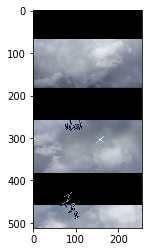

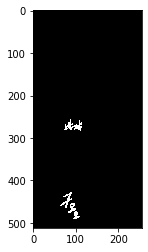

1


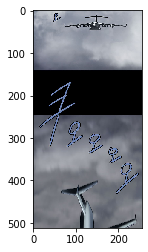

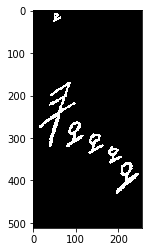

2


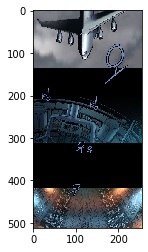

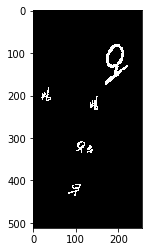

In [34]:
np.array(arrs_x).shape

(602, 512, 256, 3)

In [3]:
import os
import numpy as np

def load_data(path):
    names = sorted(os.listdir(path))
    
    files = []
    for n in names:
        # print(n)
        img = cv2.imread(path+n)
        img = cv2.resize(img, dsize=(256, 512), interpolation=cv2.INTER_AREA)
        files.append(img)
        
    x = np.stack([f for f in files], axis=0)
        
    return x




In [4]:
AUGMENTATIONS_TRAIN = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomContrast(limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    # A.CLAHE(p=1.0, clip_limit=2.0),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    A.ToFloat(max_value=255)
],p=0.5)

AUGMENTATIONS_TEST = A.Compose([
    # A.CLAHE(p=1.0, clip_limit=2.0),
    A.ToFloat(max_value=255)
])

In [5]:
model = PConvUnet(vgg_weights='data/logs/pytorch_to_keras_vgg16.h5')










[<tf.Tensor 'loss_1/outputs_img_loss/model_1/vgg16/block1_pool/MaxPool:0' shape=(?, 256, 128, 64) dtype=float32>, <tf.Tensor 'loss_1/outputs_img_loss/model_1/vgg16/block2_pool/MaxPool:0' shape=(?, 128, 64, 128) dtype=float32>, <tf.Tensor 'loss_1/outputs_img_loss/model_1/vgg16/block3_pool/MaxPool:0' shape=(?, 64, 32, 256) dtype=float32>]
[<tf.Tensor 'loss_1/outputs_img_loss/model_1_1/vgg16/block1_pool/MaxPool:0' shape=(?, ?, ?, 64) dtype=float32>, <tf.Tensor 'loss_1/outputs_img_loss/model_1_1/vgg16/block2_pool/MaxPool:0' shape=(?, ?, ?, 128) dtype=float32>, <tf.Tensor 'loss_1/outputs_img_loss/model_1_1/vgg16/block3_pool/MaxPool:0' shape=(?, ?, ?, 256) dtype=float32>]
[<tf.Tensor 'loss_1/outputs_img_loss/model_1_2/vgg16/block1_pool/MaxPool:0' shape=(?, 256, 128, 64) dtype=float32>, <tf.Tensor 'loss_1/outputs_img_loss/model_1_2/vgg16/block2_pool/MaxPool:0' shape=(?, 128, 64, 128) dtype=float32>, <tf.Tensor 'loss_1/outputs_img_loss/model_1_2/vgg16/block3_pool/MaxPool:0' shape=(?, 

In [6]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

In [7]:
batch_size = 5
# Training data
x_train = load_data('data/train/label/')
train_gen = MySequence(x_train, batch_size, augmentations=AUGMENTATIONS_TRAIN,
                       mask_generator = MaskGenerator(512, 256, 3))

# Validation data
x_val = load_data('data/vali/label/')
valid_gen = MySequence(x_val, batch_size, augmentations=AUGMENTATIONS_TEST,
                       mask_generator = MaskGenerator(512, 256, 3), seed=42)

print(x_val.shape)
print(x_train.shape)

(24, 512, 256, 3)
(316, 512, 256, 3)


In [8]:
FOLDER = 'data/logs/imagenet_phase2/'
# Training

model.fit_generator(
    train_gen, 
    steps_per_epoch=10,
    validation_data=valid_gen,
    validation_steps=10,
    epochs=10,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            FOLDER+'weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        )
#         TQDMNotebookCallback()
    ]
)

Epoch 1/10
 1/10 [==>...........................] - ETA: 2:15 - loss: 1103058.1250 - PSNR: -45.9884

KeyboardInterrupt: 